<a href="https://colab.research.google.com/github/astorguy/learn_ngspice/blob/main/notebooks/rlc/rlc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs and imports.

This notebook can be run in Google Colab or in Jupyter. However, the setup is slightly different. This function tests which environment we are in.

In [1]:
def is_running_in_colab() -> bool:
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

In [2]:
# installs
import subprocess, sys

if not is_running_in_colab():
    subprocess.run(["sudo", "apt-get", "update"], check=True)
    subprocess.run(["sudo", "apt-get", "install", "-y", "ngspice"], check=True)
else:
    subprocess.run(["apt-get", "install", "-y", "ngspice"], check=True)

subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets", "py4spice"])

Hit:1 http://deb.debian.org/debian trixie InRelease
Hit:2 http://deb.debian.org/debian trixie-updates InRelease
Hit:3 http://deb.debian.org/debian-security trixie-security InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
ngspice is already the newest version (44.2+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


0

In [3]:
# Imports
from dataclasses import dataclass
from pathlib import Path
from types import SimpleNamespace

import ipywidgets as widgets    # type: ignore
from ipywidgets import interactive  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import py4spice # type: ignore
%matplotlib inline

# Ngspice simulation of RLC

## Paths namespace
There are paths and files to define. Create `netlist` and `results` subdirectories. Make sure there is an empty transcript log file in `results` subdirectory.

In [4]:
paths = SimpleNamespace() # create the namespace for the class

paths.ngspice = Path("/usr/bin/ngspice")
paths.workspace = Path.cwd()
paths.netlists = paths.workspace /Path("netlist")
paths.results = paths.workspace / Path("results")
paths.top = paths.netlists / Path("top.cir")
paths.sim_transcript = paths.results / Path("sim_transcript.log")

# create these directories if the don't yet exist
paths.netlists.mkdir(parents=True, exist_ok=True)
paths.results.mkdir(parents=True, exist_ok=True)

# create an empty file for sim_transcript
paths.sim_transcript.write_text("")

0

### Netlists namespace
Netlist objects are created. These netlist snippets will be used later to create a single top-level netlist which will be read in during the batch simulation. Again, we put them into a namespace to keep things organized.

In [5]:
netlists = SimpleNamespace() # create the namespace for the class

netlists.blankline = py4spice.Netlist("")
netlists.title = py4spice.Netlist("* my ngspice netlist")
netlists.end = py4spice.Netlist(".end")

### Vectors namespace
Vectors objects are used to define a set of circuit signals to create and display. Again, we put them into a namespace to keep things organized.

In [6]:
vectors = SimpleNamespace() # create the namespace for the class

vectors.all = py4spice.Vectors("all")
vectors.out = py4spice.Vectors("out")
vectors.vil_branch = py4spice.Vectors("vil#branch")
vectors.vic_branch = py4spice.Vectors("vic#branch")
vectors.currents = vectors.vil_branch + vectors.vic_branch
vectors.I_inductor = py4spice.Vectors("I_inductor") # rename for nice plots
vectors.I_capacitor = py4spice.Vectors("I_capacitor") # rename for nice plots
vectors.currents_renamed = vectors.I_inductor + vectors.I_capacitor

### Circuit parameters dataclass
Define the circuit parameters we will be vary during simulations

In [7]:
@dataclass
class CircuitParams:
    L: float
    C: float
    R: float
    ic: float   # initial current through inductor
    tend: float # time end for the tranisent simulation

# initial values
params = CircuitParams(L=10e-6, C=10e-9, R=100, ic=300e-3, tend=5e-6)

### ***Function:*** Simulation process function
Prepare top netlist and simulate. We put this in a function so we can easily modify parameters and loop.

In [8]:
def sim_process(params):
    ''' There are several steps to the simulation process:
    1. Create list of analyses to run
    2. Create the control section
    3. Create DUT netlist object
    4. Construct the top netlist from control, DUT, and snippets
    5. Prepare Ngspice command
    6. Run the Ngspice simulation
    7. Create SimResults objects from the raw Ngspice output
    8. Create Waveforms objects from the SimResults objects
    '''
    # 1. Create list of analyses to run
    # ---------------------------------
    # (in our case only one analysis)
    list_of_analyses = []  # start with an empty list

    # 1st analysis: operating point (in our case, we have only one analysis)
    tran1 = py4spice.Analyses(
        name="tran1",
        cmd_type="tran",
        cmd=f"tran 1e-9 {params.tend} uic",
        vector=vectors.all,
        results_loc=paths.results,
    )
    list_of_analyses.append(tran1)


    # 2. Create the control section
    # -----------------------------
    my_control = py4spice.Control()  # create 'my_control' object

    # add all the analyses defined above into the control section
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())

    # convert control section into a netlist object
    netlists.control = py4spice.Netlist(str(my_control))


    # 3. Create DUT netlist object
    # ----------------------------
    netlists.L = py4spice.Netlist(f"l1 out lmid {params.L} ic={params.ic}")
    netlists.vil = py4spice.Netlist("vil lmid 0 dc 0")
    netlists.c = py4spice.Netlist(f"c1 out cmid {params.C}")
    netlists.vic = py4spice.Netlist("vic cmid 0 dc 0")
    netlists.R = py4spice.Netlist(f"r1 out 0 {params.R}")

    netlists.dut = (
    netlists.L
    + netlists.vil
    + netlists.c
    + netlists.vic
    + netlists.R
    )
    # print(netlists.dut)


    # 4. Construct the top netlist from control, DUT, and snippets
    # ------------------------------------------------------------
    # concatenate netlist snippets to construct top
    netlists.top = (
        netlists.title
        + netlists.blankline
        + netlists.dut
        + netlists.blankline
        + netlists.control
        + netlists.blankline
        + netlists.end
        + netlists.blankline
        )
    # write netlist to a file so ngspice can read it
    netlists.top.write_to_file(paths.top)
    # print(netlists.top)

    # 5. Prepare Ngspice command
    # --------------------------
    # prepare simulate object and simulate
    sim = py4spice.Simulate(
        ngspice_exe=paths.ngspice,
        netlist_filename=paths.top,
        transcript_filename=paths.sim_transcript,
        name="sim1",
        timeout=5,
    )
    # print(sim.ngspice_command)

    # 6. Run the Ngspice simulation
    # -----------------------------
    sim.run()


    # 7. Create SimResults objects from the raw Ngspice output
    # --------------------------------------------------------
    sim_results: list[py4spice.SimResults] = [
        py4spice.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]


    # 8. Create Waveforms objects from the SimResults objects
    # -------------------------------------------------------
    out_waves = py4spice.Waveforms(
        sim_results[0].header, sim_results[0].data_plot
        )

    return out_waves

### ***Function:*** Prepare waveforms
Reduces the set of `py4spice.Waveforms` and renames waves to better descriptions.

In [9]:
def prepare_waveforms(waves):

    # reduce waveform set to just currents
    waves.vec_subset(vectors.currents.list_out())

    # rename inductor current to a better name
    waves.scaler(1.0, vectors.vil_branch.list_out()[0], vectors.I_inductor.list_out()[0])

    # rename capacitor current to a better name    
    waves.scaler(1.0, vectors.vic_branch.list_out()[0], vectors.I_capacitor.list_out()[0])
    return

### ***Function:*** Generate & display plot
Uses py4spice.Plot

In [10]:
def generate_plot(waves, params):

    # prepare plot
    plot_data = waves.x_axis_and_sigs(vectors.currents_renamed.list_out())
    y_names = vectors.currents_renamed.list_out()

    # plot
    my_plt = py4spice.Plot("tr_plt", plot_data, y_names, paths.results)

    # add to plot
    my_plt.set_title("RLC Transient Simulation Results")
    my_plt.define_axes(("time", "sec", "linear"), ("amps", "A", "linear"))

    # Add parameter values to the plot as text
    # Get the current axes to place text relative to data coordinates
    # Or use figtext for relative figure coordinates if axes are tricky
    # For simplicity, using plt.figtext which places text relative to the figure.
    plt.figtext(0.7, 0.81, f"L: {params.L*1e6:.1f} uH", fontsize=10, ha='left')
    plt.figtext(0.7, 0.79, f"C: {params.C*1e9:.1f} nF", fontsize=10, ha='left')
    plt.figtext(0.7, 0.77, f"R: {params.R:.1f} Ohm", fontsize=10, ha='left')
    plt.figtext(0.7, 0.75, f"ic: {params.ic*1e3:.1f} mA", fontsize=10, ha='left')
    plt.figtext(0.7, 0.73, f"tend: {params.tend*1e6:.1f} uSec", fontsize=10, ha='left')

### ***Function:*** Simulate and Plot

In [11]:
def sim_and_plot(params):
    out_waves = sim_process(params)
    prepare_waveforms(out_waves)
    generate_plot(out_waves, params) # Pass params to generate_plot

### ***Function:*** Interactive simulation and Plot
Called by the sliders. This function calls the `sim_and_plot` function.

In [12]:
def interactive_simulation_and_plot(L_value, C_value, R_value, ic_value, tend_value):
    # Apply the multiplication factors
    L_scaled = L_value * 1e-6
    C_scaled = C_value * 1e-9
    R_scaled = R_value * 1
    ic_scaled = ic_value * 1e-3
    tend_scaled = tend_value * 1e-6

    temp_params = CircuitParams(L=L_scaled, C=C_scaled, R=R_scaled, ic=ic_scaled, tend=tend_scaled)
    sim_and_plot(temp_params)

## Interactive sliders
Iteractive sliders linked to the simulation function. This enables dynamic changes to the parameters, resimulating and ploting.

interactive(children=(FloatSlider(value=10.000000000000002, description='iL (uH)', min=1.0, step=1.0), FloatSl…

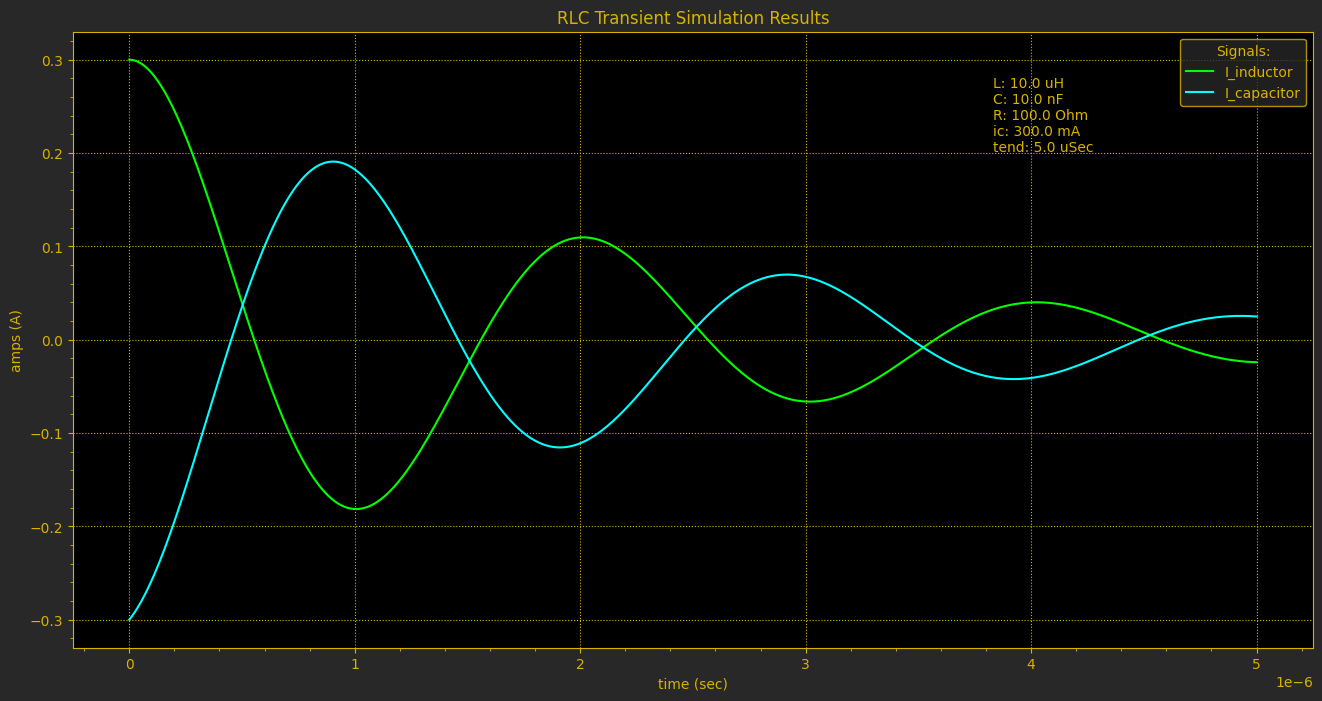

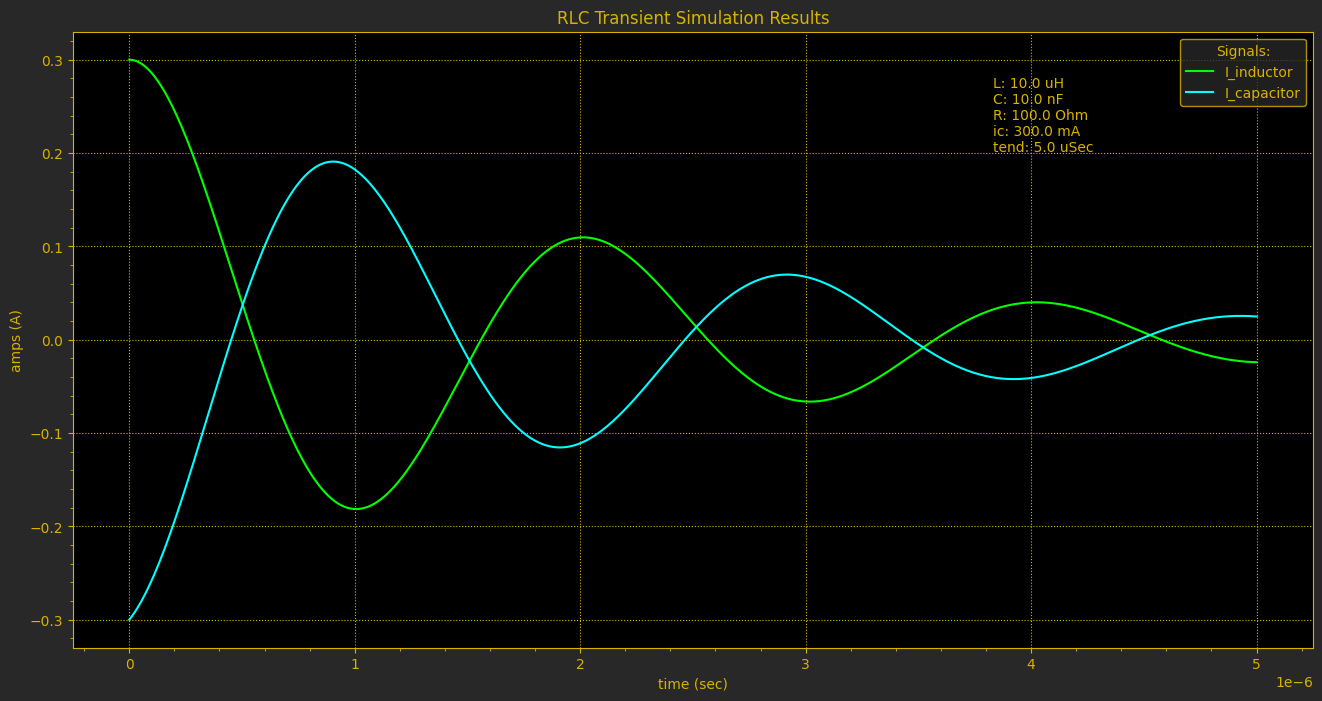

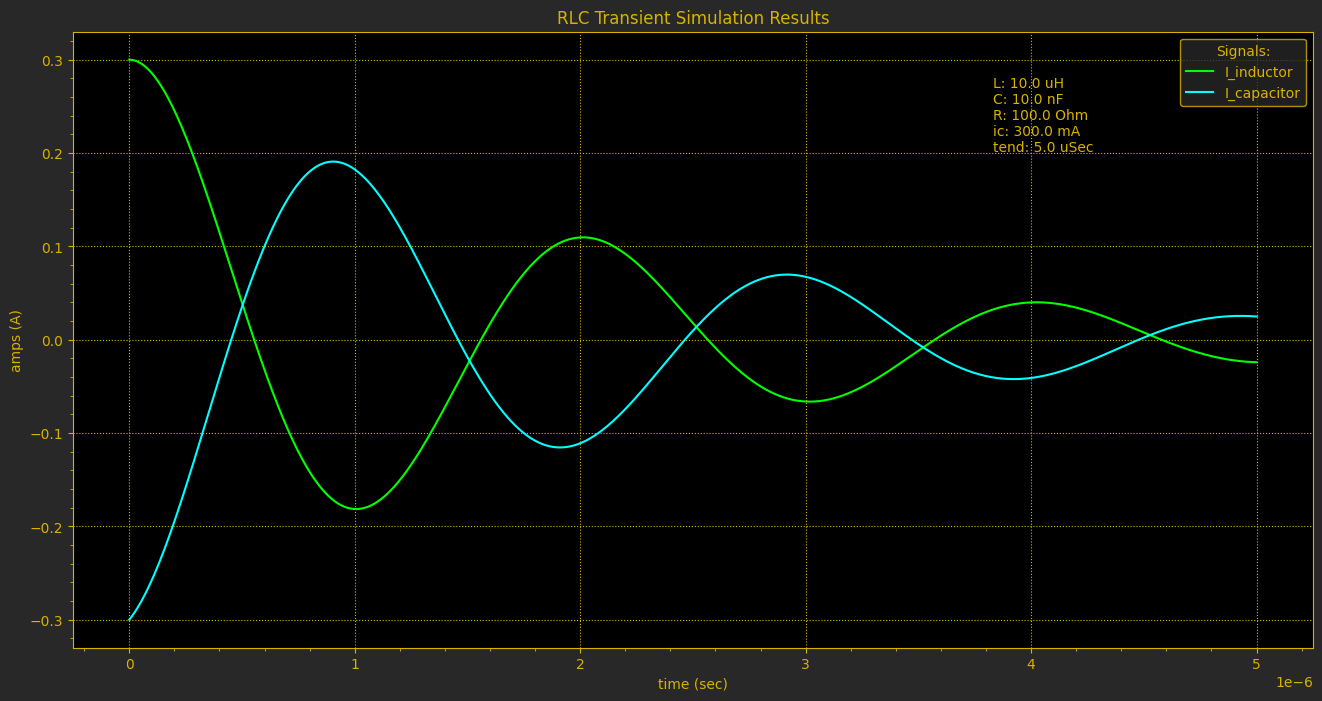

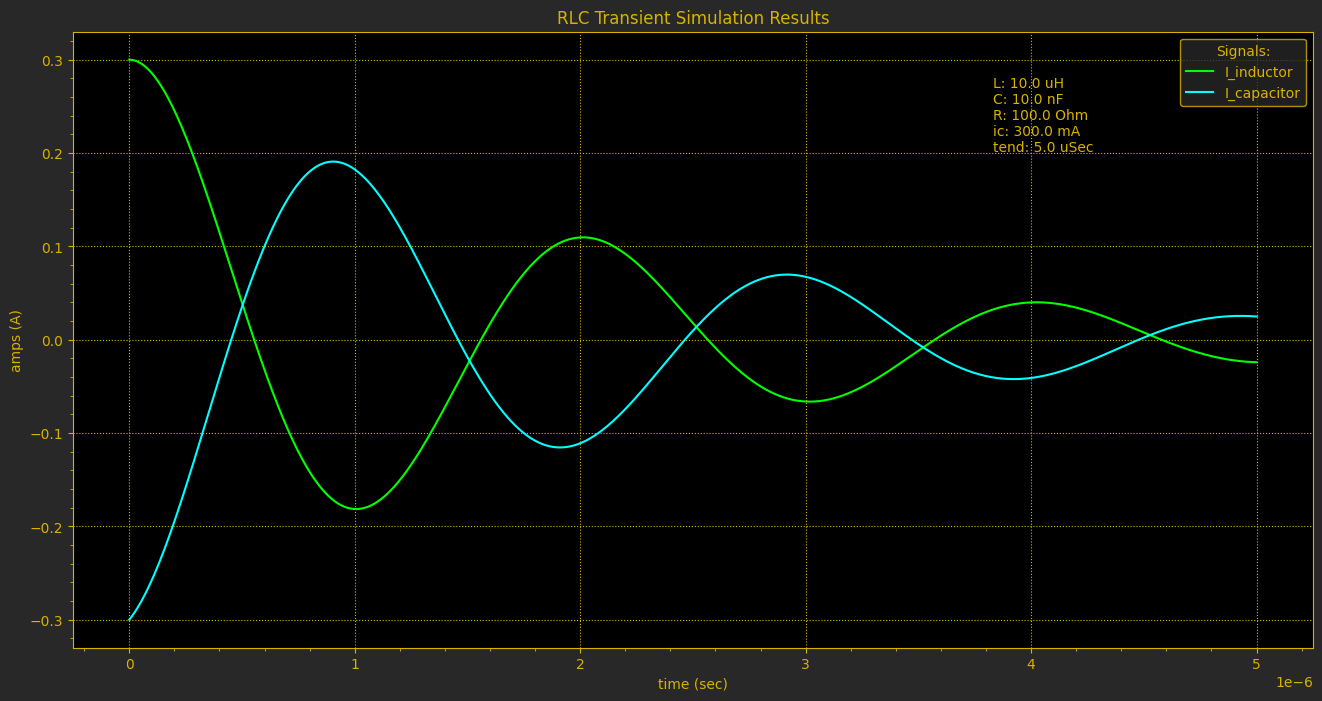

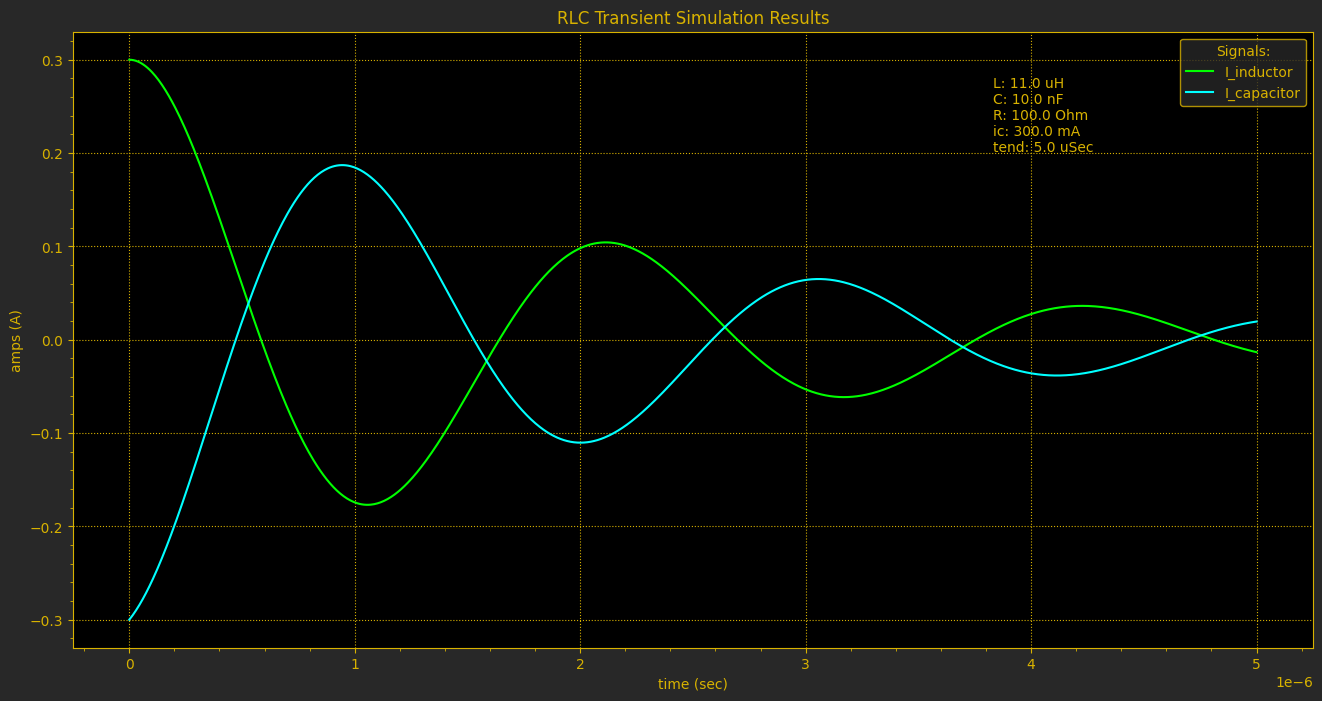

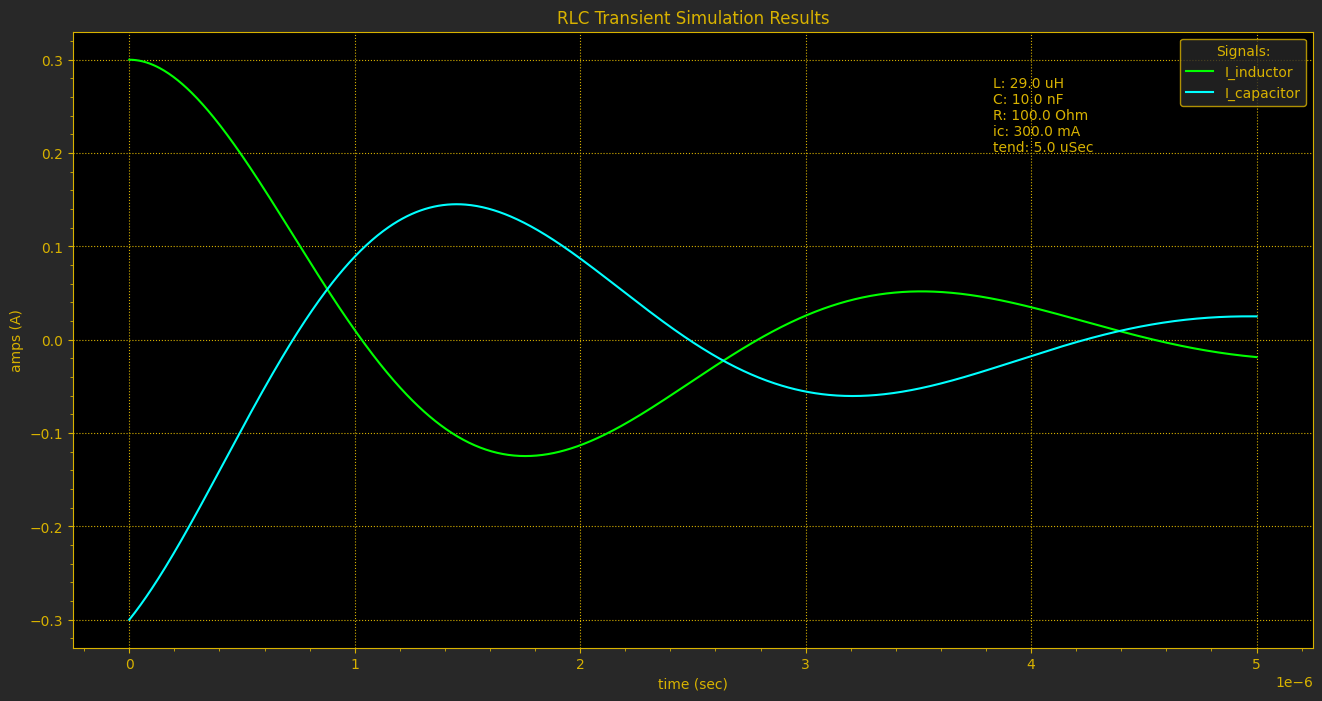

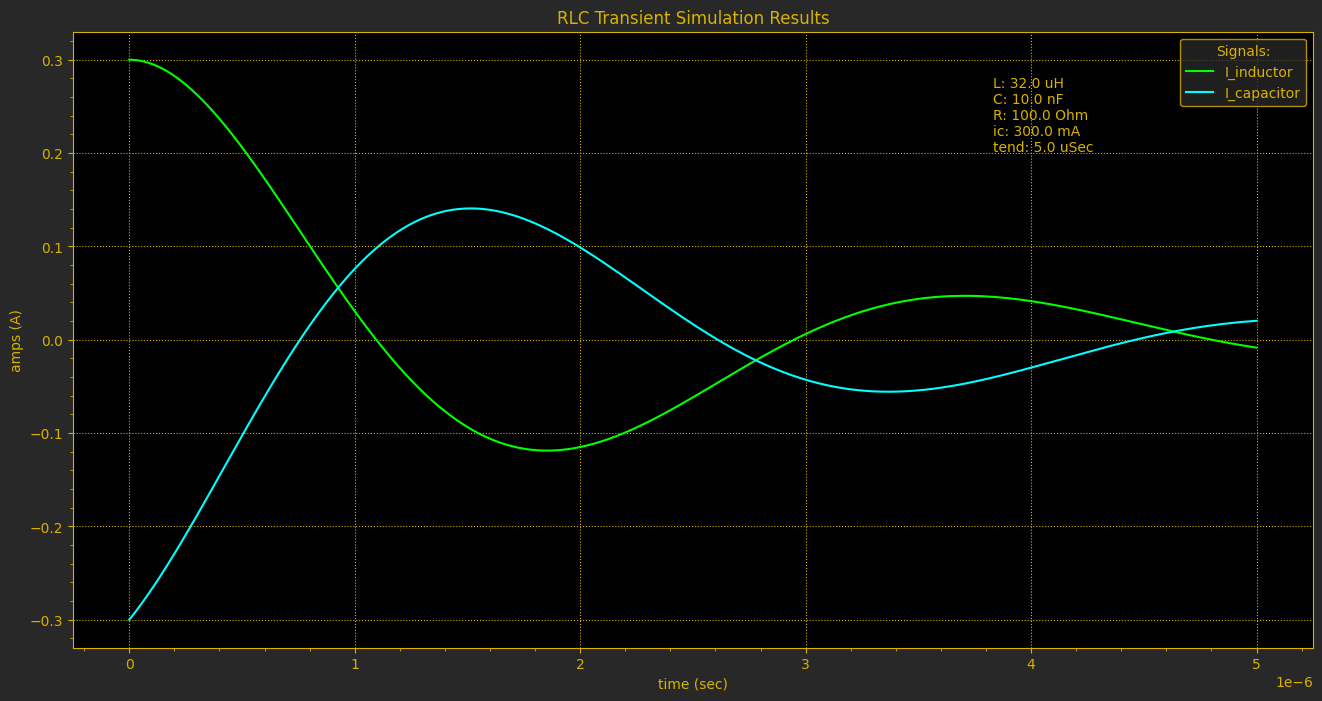

In [13]:
interactive_plot_widget = interactive(
    interactive_simulation_and_plot,
    L_value=widgets.FloatSlider(
        min=1, max=100, step=1, value=params.L / 1e-6, description='iL (uH)'
    ),
    C_value=widgets.FloatSlider(
        min=1, max=100, step=1, value=params.C / 1e-9, description='iC (nF)'
    ),
    R_value=widgets.FloatSlider(
        min=1, max=500, step=1, value=params.R / 1, description='R (ohm)'
    ),
    ic_value=widgets.FloatSlider(
        min=1, max=1000, step=1, value=params.ic / 1e-3, description='ic initial (mA)'
    ),
    tend_value=widgets.FloatSlider(
        min=1, max=100, step=1, value=params.tend / 1e-6, description='tend (uSec)'
    )
)
display(interactive_plot_widget);